# Machine Learning Approaches to L/S-TLF

## LSTM (Long Short-Term Memory)

### Loading and Cleaning Data

This will also include exogenous variables: temperature, windspeed, and (proxied) sun coverage. A lot of this initial code will be exactly the same as in the TR notebook.

N.B. The variable naming convention:

- `.lt..` denotes long-term data (monthly over years)
- `.st..` denotes short-term data (daily over one year)
- `...oc` denotes one-column data (without exogenous variables)
- `...mc` denotes multi-column data (with exogenous variables)
- `g....` in front of a variable denotes that it will be the GRU variant (LSTM by default)

- `sc..` means scaled
- `..tr`, `..vl`, `..ts` mean training, validation, and test sets respectively

- `X..` is the input (I know this would typically indicate a constant variable in Python, but it is more consistent with mathematical notation)
- `y..` is the label

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from typing import Type, Optional
import pandera as pa
from pandera.typing import Series, DataFrame
from pandera.dtypes import Int64, DateTime, Timedelta

import meteostat as met

from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("Data/Demand_Data_09to24.csv")

df = df[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ND", "EMBEDDED_SOLAR_GENERATION", "EMBEDDED_SOLAR_CAPACITY"]]

In [3]:
def sett2date(date_: DateTime, sp_: int) -> DateTime:
    return (
        date_ + pd.Timedelta(30, "m") * sp_ - pd.Timedelta(15, "m")
    )

In [4]:
def conv_date(date_series: Series[DateTime], sett_period_series: Series[Int64]) -> Series[DateTime]:
    zipped = zip(date_series, sett_period_series)
    
    true_dt = pd.Series([sett2date(date_, sp_) for date_, sp_ in zipped])

    return true_dt

In [5]:
df["SETTLEMENT_DATE"] = pd.Series([pd.to_datetime(x) for x in df["SETTLEMENT_DATE"]])

In [6]:
df["DATETIME"] = conv_date(df["SETTLEMENT_DATE"], df["SETTLEMENT_PERIOD"])

In [7]:
# timeseries data breakout
df["YEAR_MONTH"] = df["DATETIME"].values.astype("<M8[M]")
df["YMD"] = df["DATETIME"].values.astype("<M8[D]")

# sun_data proxy
df["sun_eff"] = pd.Series(df["EMBEDDED_SOLAR_GENERATION"] / df["EMBEDDED_SOLAR_CAPACITY"])

In [8]:
df.head()

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,DATETIME,YEAR_MONTH,YMD,sun_eff
0,2009-01-01,1,37910,0,0,2009-01-01 00:15:00,2009-01-01,2009-01-01,NaN
1,2009-01-01,2,38047,0,0,2009-01-01 00:45:00,2009-01-01,2009-01-01,NaN
2,2009-01-01,3,37380,0,0,2009-01-01 01:15:00,2009-01-01,2009-01-01,NaN
3,2009-01-01,4,36426,0,0,2009-01-01 01:45:00,2009-01-01,2009-01-01,NaN
4,2009-01-01,5,35687,0,0,2009-01-01 02:15:00,2009-01-01,2009-01-01,NaN


Weather Data (as in TR)

In [9]:
w_start = datetime.datetime(2011, 1, 1)
w_end = datetime.datetime(2024, 6, 1)

ldn = met.Point(51.469714, -0.463319)
edi = met.Point(55.949920, -3.359142)
cdf = met.Point(51.409223, -3.433527)

In [10]:
ldn_wdat = met.Monthly(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_wdat = met.Monthly(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_wdat = met.Monthly(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [11]:
sun_factor_09 = df[["YEAR_MONTH", "sun_eff"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")
sun_data = sun_factor_09[(sun_factor_09.index >= pd.to_datetime("2011-01-01"))]

combined_wdat = pd.concat([ldn_wdat, edi_wdat, cdf_wdat, sun_data], axis=1)

mean_wdat = combined_wdat.T.groupby(combined_wdat.columns).agg("mean").T

In [12]:
mean_wdat.head()

,sun_eff,tavg,wspd
2011-01-01,0.018301,5.300,14.400
2011-02-01,0.026512,7.500,18.000
2011-03-01,0.068665,8.925,15.775
2011-04-01,0.117791,13.100,13.550
2011-05-01,0.125091,13.580,14.300


In [13]:
ltoc = df[["YEAR_MONTH", "ND"]].groupby("YEAR_MONTH").agg("mean").asfreq("MS")

In [14]:
scaler_ltoc = MinMaxScaler(feature_range=(0, 1))

In [15]:
agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")

scaler_ltoc.fit(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])

sctr_ltoc = scaler_ltoc.transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
scvl_ltoc = scaler_ltoc.transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
scts_ltoc = scaler_ltoc.transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])

Some of the following code has been taken from the very helpful tutorial by Greg Hogg (https://www.youtube.com/watch?v=c0k-YLQGKjY, https://colab.research.google.com/drive/1HxPsJvEAH8L7XTmLnfdJ3UQx7j0o1yX5?usp=sharing#scrollTo=EbrFD1vMR_qS). These resources and other miscellaneous StackExchange threads on parameter selection and tuning have been use to construct the following models.

In [16]:
def col_Xy(col: Series, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(col)-seasonal_order):
    window = [a for a in col[i:i+seasonal_order]]
    X.append(window)
    label = col[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

The function takes the previous `seasonal_order` number of values and then labels them with the `seasonal_order + 1`-th value

In [17]:
SEASON_LTLF = 11

11 is chosen because we want to predict the 12th value based on the previous 11. The idea is that the window size (ML `seasonal_order`) is the traditional seasonal order - 1.

In [18]:
Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)

In [19]:
Xtr_ltoc[0]

array([[0.92964219],
       [0.88378702],
       [0.6664977 ],
       [0.44309417],
       [0.3433566 ],
       [0.34481605],
       [0.31615413],
       [0.2784782 ],
       [0.3665271 ],
       [0.48840659],
       [0.63882912]])

In [20]:
ytr_ltoc[0]

array([0.82318279])

In [21]:
Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)

### Running the LTLF

First I build the model, as shown in much of the documentation, StackOverflow recommendations, and various tutorials online

In [22]:

ltoc_model = Sequential()
ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
ltoc_model.add(LSTM(128, return_sequences=True))
ltoc_model.add(LSTM(128))
ltoc_model.add(Dense(8, 'relu'))
ltoc_model.add(Dense(1, 'linear'))

ltoc_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

I set a checkpoint for the epochs so that we can load the optimal model later and I compile the model.

In [23]:
cp = ModelCheckpoint('models/ltoc_model.keras', save_best_only=True)
ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

Finally, I fit the model.

In [24]:
ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.2356 - root_mean_squared_error: 0.4847 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2480
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0949 - root_mean_squared_error: 0.3079 - val_loss: 0.0698 - val_root_mean_squared_error: 0.2643
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0764 - root_mean_squared_error: 0.2762 - val_loss: 0.0821 - val_root_mean_squared_error: 0.2865
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0737 - root_mean_squared_error: 0.2713 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0646 - root_mean_squared_error: 0.2541 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2415
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0763 - root_mean_squared_error: 0.2761 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0670 - roo

Load the best model.

In [25]:
ltoc_model = load_model('models/ltoc_model.keras')

I unscale the data.

In [26]:
pred_ltoc = ltoc_model.predict(Xts_ltoc)
pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)

yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


I plot the predicted values on the actuals to see how well the model did, and I output the MAPE.

In [27]:
def plot_fcast_ml(agg_data: DataFrame, val_start: str, test_start: str, test_end: str, pred_arr: np.ndarray, exog: bool) -> None:
    
    if exog:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]["ND"]
    else:
        actualized_df = agg_data[(agg_data.index >= pd.to_datetime(val_start)) & (agg_data.index < pd.to_datetime(test_end))]
    
    dates_ts = actualized_df[actualized_df.index >= pd.to_datetime(test_start)].index.to_list()

    pred_arr = pd.Series(pred_arr.flatten())
    
    pred_arr.index = dates_ts

    with plt.style.context([ 
        {'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        }
        ]):

        fig, ax = plt.subplots(figsize=(6, 5))

        ax.grid(visible=True, linewidth=0.5)
        
        [x.set_linewidth(0.15) for x in ax.spines.values()]

        ax.tick_params(left=False, bottom=False)

        ax.plot(actualized_df, label='Actual', color="C0")
        ax.plot(pred_arr, label='Predicted', color="orange")

        plt.ylim(0, 50000)

        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("National Demand (MW)")
        plt.xticks(rotation=45)

    plt.show()

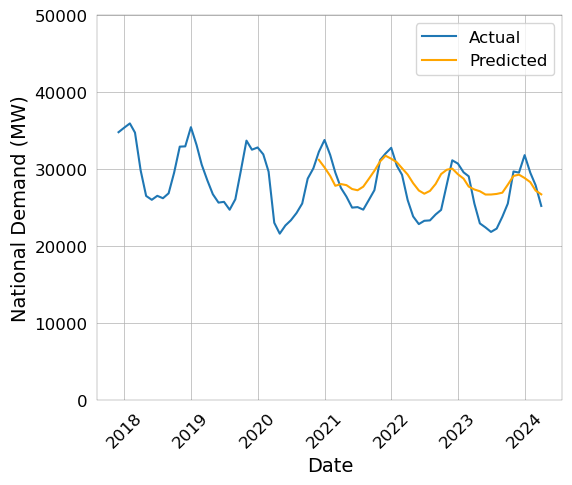


MAPE: 9.012%
RMSE: 2694.0236623852898
R2  : 0.36244265144297927



In [28]:
plot_fcast_ml(agg_ltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltoc, False)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_ltoc, pred_ltoc)}
R2  : {r2_score(yts_ltoc, pred_ltoc)}
""")

This process will be repeated 7 more times with LSTM/GRU and `..oc`, `..mc` inputs. This process will be condensed into a single function for each model, including this one, for repeated running of the models.

In [29]:
def ltoc_run() -> list[float]:
    global pred_ltoc
    global yts_ltoc

    scaler_ltoc = MinMaxScaler(feature_range=(0, 1))
    
    # Aggregating and filtering the data
    agg_ltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    
    # Fit scaler on training data
    scaler_ltoc.fit(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    
    # Transform all data using the same scaler
    sctr_ltoc = scaler_ltoc.transform(agg_ltoc[agg_ltoc.index < pd.to_datetime("2017-01-01")])
    scvl_ltoc = scaler_ltoc.transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2017-01-01")) & (agg_ltoc.index < pd.to_datetime("2020-01-01"))])
    scts_ltoc = scaler_ltoc.transform(agg_ltoc[(agg_ltoc.index >= pd.to_datetime("2020-01-01")) & (agg_ltoc.index < pd.to_datetime("2024-05-01"))])
    
    # Generate X and y for train, validation, and test sets
    Xtr_ltoc, ytr_ltoc = col_Xy(sctr_ltoc, SEASON_LTLF)
    Xvl_ltoc, yvl_ltoc = col_Xy(scvl_ltoc, SEASON_LTLF)
    Xts_ltoc, yts_ltoc = col_Xy(scts_ltoc, SEASON_LTLF)
    
    # Model construction
    ltoc_model = Sequential()
    ltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    ltoc_model.add(LSTM(128, return_sequences=True))
    ltoc_model.add(LSTM(128))
    ltoc_model.add(Dense(8, activation='relu'))
    ltoc_model.add(Dense(1, activation='linear'))
    
    # Compile model
    ltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    # Train model
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltoc_model.fit(Xtr_ltoc, ytr_ltoc, validation_data=(Xvl_ltoc, yvl_ltoc), epochs=50, callbacks=[cp], verbose=0)
    
    # Load the best model and make predictions
    ltoc_model = load_model('intermediate.keras')
    pred_ltoc = ltoc_model.predict(Xts_ltoc, verbose=0)
    
    # Inverse transform predictions and true values
    pred_ltoc = scaler_ltoc.inverse_transform(pred_ltoc)
    yts_ltoc = scaler_ltoc.inverse_transform(yts_ltoc)
    
    # Calculate MAPE, RMSE, R2
    return [mean_absolute_percentage_error(yts_ltoc, pred_ltoc) * 100, root_mean_squared_error(yts_ltoc, pred_ltoc), r2_score(yts_ltoc, pred_ltoc)]


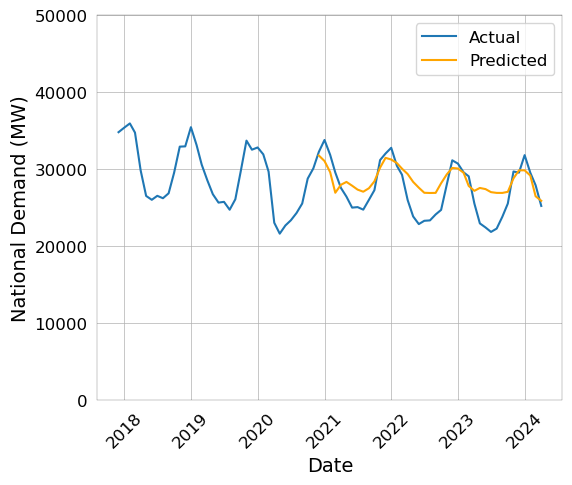


MAPE: 8.354%
RMSE: 2569.4861802156115
R2  : 0.42002534346250475



In [64]:
ltoc_run()

plot_fcast_ml(agg_ltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltoc, False)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_ltoc, pred_ltoc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_ltoc, pred_ltoc)}
R2  : {r2_score(yts_ltoc, pred_ltoc)}
""")

### LTLF with Exogenous Variables

In [31]:
def df_Xy(df: DataFrame, seasonal_order: int) -> (np.ndarray, np.ndarray):
  X = []
  y = []
  for i in range(len(df)-seasonal_order):
    row = [a for a in df[i:i+seasonal_order]]
    X.append(row)
    label = df[i+seasonal_order]
    y.append(label)
  return np.array(X), np.array(y)

This is a modified col_Xy built for `..mc` datasets.

In [32]:
ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")

In [33]:
def ltmc_run() -> list[float]:
    global pred_ltmc
    global yts_ltmc

    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    
    scaler_ltmc = MinMaxScaler(feature_range=(0, 1))
    
    scaler_ltmc.fit(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    
    sctr_ltmc = scaler_ltmc.transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_ltmc = scaler_ltmc.transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_ltmc = scaler_ltmc.transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    
    Xtr_ltmc, ytr_ltmc = df_Xy(sctr_ltmc, SEASON_LTLF)
    Xvl_ltmc, yvl_ltmc = df_Xy(scvl_ltmc, SEASON_LTLF)
    Xts_ltmc, yts_ltmc = df_Xy(scts_ltmc, SEASON_LTLF)
    
    ltmc_model = Sequential()
    ltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    ltmc_model.add(LSTM(512, return_sequences=True))
    ltmc_model.add(LSTM(256))
    ltmc_model.add(Dense(32, 'relu'))
    ltmc_model.add(Dense(4, 'linear'))
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    ltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    ltmc_model.fit(Xtr_ltmc, ytr_ltmc, validation_data=(Xvl_ltmc, yvl_ltmc), epochs=50, callbacks=[cp], verbose=0)
    
    ltmc_model = load_model('intermediate.keras')
    pred_ltmc = ltmc_model.predict(Xts_ltmc, verbose=0)
    
    pred_ltmc = scaler_ltmc.inverse_transform(pred_ltmc)[:,0]
    yts_ltmc = scaler_ltmc.inverse_transform(yts_ltmc)[:,0]

    return [mean_absolute_percentage_error(yts_ltmc, pred_ltmc) * 100, root_mean_squared_error(yts_ltmc, pred_ltmc), r2_score(yts_ltmc, pred_ltmc)]

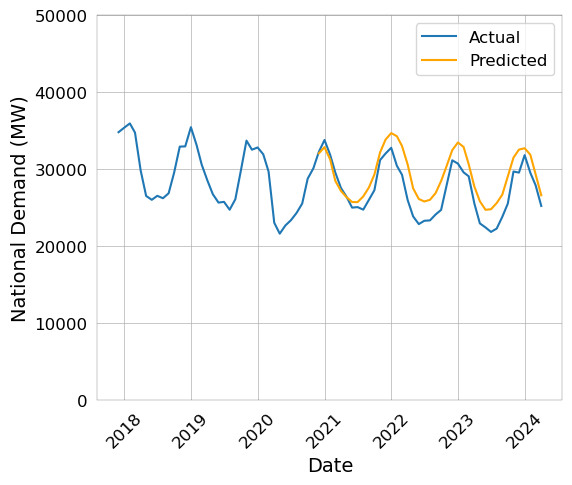


MAPE: 8.162%
RMSE: 2420.1761795328125
R2  : 0.485470347707337



In [63]:
ltmc_run()

plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_ltmc, True)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_ltmc, pred_ltmc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_ltmc, pred_ltmc)}
R2  : {r2_score(yts_ltmc, pred_ltmc)}
""")

### STLF

In [35]:
SEASON_STLF = 6

In [36]:
stoc = df[["YMD", "ND"]].groupby("YMD").agg("mean").asfreq("D")

In [37]:
w_start = datetime.datetime(2022, 1, 1)
w_end = datetime.datetime(2022, 12, 31)

In [38]:
ldn_dwdat = met.Daily(ldn, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
edi_dwdat = met.Daily(edi, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]
cdf_dwdat = met.Daily(cdf, start=w_start, end=w_end).fetch().interpolate()[["tavg", "wspd"]]

In [39]:
sun_dfactor = df[["YMD", "sun_eff"]].groupby("YMD").agg("mean").asfreq("D")
sun_ddata = sun_dfactor[(sun_dfactor.index >= pd.to_datetime("2022-01-01")) & (sun_dfactor.index <= pd.to_datetime("2022-12-31"))]

combined_dwdat = pd.concat([ldn_dwdat, edi_dwdat, cdf_dwdat, sun_ddata], axis=1)

mean_dwdat = combined_dwdat.T.groupby(combined_dwdat.columns).agg("mean").T

In [44]:
def stoc_run() -> list[float]:
    global pred_stoc
    global yts_stoc
    global agg_stoc

    scaler_stoc = MinMaxScaler(feature_range=(0, 1))
    
    agg_stoc = stoc[(stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31"))].asfreq("D")
    
    scaler_stoc.fit(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
    
    sctr_stoc = scaler_stoc.transform(agg_stoc[agg_stoc.index < pd.to_datetime("2022-05-01")])
    scvl_stoc = scaler_stoc.transform(agg_stoc[(agg_stoc.index >= pd.to_datetime("2022-05-01")) & (agg_stoc.index < pd.to_datetime("2022-07-15"))])
    scts_stoc = scaler_stoc.transform(agg_stoc[agg_stoc.index >= pd.to_datetime("2022-07-15")])
    
    Xtr_stoc, ytr_stoc = df_Xy(sctr_stoc, SEASON_STLF)
    Xvl_stoc, yvl_stoc = df_Xy(scvl_stoc, SEASON_STLF)
    Xts_stoc, yts_stoc = df_Xy(scts_stoc, SEASON_STLF)
    
    stoc_model = Sequential()
    stoc_model.add(InputLayer((SEASON_STLF, 1)))
    stoc_model.add(LSTM(256, return_sequences=True))
    stoc_model.add(LSTM(256))
    stoc_model.add(Dense(8, activation='relu'))
    stoc_model.add(Dense(1, activation='linear'))
    
    stoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stoc_model.fit(Xtr_stoc, ytr_stoc, validation_data=(Xvl_stoc, yvl_stoc), epochs=50, callbacks=[cp], verbose=0)
    
    stoc_model = load_model('intermediate.keras')
    pred_stoc = stoc_model.predict(Xts_stoc, verbose=0)
    
    pred_stoc = scaler_stoc.inverse_transform(pred_stoc)
    yts_stoc = scaler_stoc.inverse_transform(yts_stoc)
    
    return [mean_absolute_percentage_error(yts_stoc, pred_stoc) * 100, root_mean_squared_error(yts_stoc, pred_stoc), r2_score(yts_stoc, pred_stoc)]

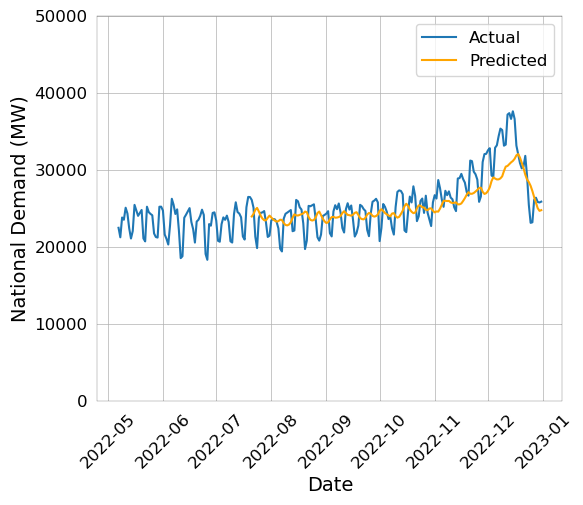


MAPE: 7.857%
RMSE: 2604.396180917182
R2  : 0.5400190707133796



In [45]:
stoc_run()

plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stoc, False)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_stoc, pred_stoc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_stoc, pred_stoc)}
R2  : {r2_score(yts_stoc, pred_stoc)}
""")

### STLF with Exogenous Variables

In [46]:
stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")

In [47]:
def stmc_run() -> list[float]:
    global pred_stmc
    global yts_stmc

    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    
    scaler_stmc = MinMaxScaler(feature_range=(0, 1))
    
    scaler_stmc.fit(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    
    sctr_stmc = scaler_stmc.transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_stmc = scaler_stmc.transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_stmc = scaler_stmc.transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    
    Xtr_stmc, ytr_stmc = df_Xy(sctr_stmc, SEASON_STLF)
    Xvl_stmc, yvl_stmc = df_Xy(scvl_stmc, SEASON_STLF)
    Xts_stmc, yts_stmc = df_Xy(scts_stmc, SEASON_STLF)
    
    stmc_model = Sequential()
    stmc_model.add(InputLayer((SEASON_STLF, 4)))
    stmc_model.add(LSTM(512, return_sequences=True))
    stmc_model.add(LSTM(512))
    stmc_model.add(Dense(32, 'relu'))
    stmc_model.add(Dense(4, 'linear'))
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    stmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    stmc_model.fit(Xtr_stmc, ytr_stmc, validation_data=(Xvl_stmc, yvl_stmc), epochs=50, callbacks=[cp], verbose=0)
    
    stmc_model = load_model('intermediate.keras')
    pred_stmc = stmc_model.predict(Xts_stmc, verbose=0)
    pred_stmc = scaler_stmc.inverse_transform(pred_stmc)[:,0]
    
    yts_stmc = scaler_stmc.inverse_transform(yts_stmc)[:,0]

    return [mean_absolute_percentage_error(yts_stmc, pred_stmc) * 100, root_mean_squared_error(yts_stmc, pred_stmc), r2_score(yts_stmc, pred_stmc)]

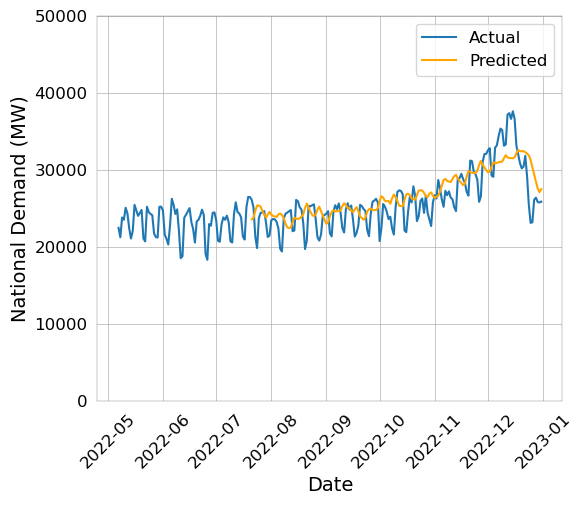


MAPE: 8.407%
RMSE: 2676.057135647866
R2  : 0.5143577193013577



In [71]:
stmc_run()

plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_stmc, True)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_stmc, pred_stmc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_stmc, pred_stmc)}
R2  : {r2_score(yts_stmc, pred_stmc)}
""")

## GRU (Gated Recurrent Unit)

### LTLF

In [51]:
def gltoc_run() -> list[float]:
    global pred_gltoc
    global yts_gltoc
    global agg_gltoc
    
    scaler_gltoc = MinMaxScaler(feature_range=(0, 1))
    
    agg_gltoc = ltoc[ltoc.index >= pd.to_datetime("2009-01-01")].asfreq("MS")
    
    scaler_gltoc.fit(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    
    sctr_gltoc = scaler_gltoc.transform(agg_gltoc[agg_gltoc.index < pd.to_datetime("2017-01-01")])
    scvl_gltoc = scaler_gltoc.transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2017-01-01")) & (agg_gltoc.index < pd.to_datetime("2020-01-01"))])
    scts_gltoc = scaler_gltoc.transform(agg_gltoc[(agg_gltoc.index >= pd.to_datetime("2020-01-01")) & (agg_gltoc.index < pd.to_datetime("2024-05-01"))])
    
    Xtr_gltoc, ytr_gltoc = col_Xy(sctr_gltoc, SEASON_LTLF)
    Xvl_gltoc, yvl_gltoc = col_Xy(scvl_gltoc, SEASON_LTLF)
    Xts_gltoc, yts_gltoc = col_Xy(scts_gltoc, SEASON_LTLF)
    
    gltoc_model = Sequential()
    gltoc_model.add(InputLayer((SEASON_LTLF, 1)))
    gltoc_model.add(LSTM(128, return_sequences=True))
    gltoc_model.add(LSTM(128))
    gltoc_model.add(Dense(8, activation='relu'))
    gltoc_model.add(Dense(1, activation='linear'))
    
    gltoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltoc_model.fit(Xtr_gltoc, ytr_gltoc, validation_data=(Xvl_gltoc, yvl_gltoc), epochs=50, callbacks=[cp], verbose=0)
    
    gltoc_model = load_model('intermediate.keras')
    pred_gltoc = gltoc_model.predict(Xts_gltoc, verbose=0)
    
    pred_gltoc = scaler_gltoc.inverse_transform(pred_gltoc)
    yts_gltoc = scaler_gltoc.inverse_transform(yts_gltoc)
    
    return [mean_absolute_percentage_error(yts_gltoc, pred_gltoc) * 100, root_mean_squared_error(yts_gltoc, pred_gltoc), r2_score(yts_gltoc, pred_gltoc)]


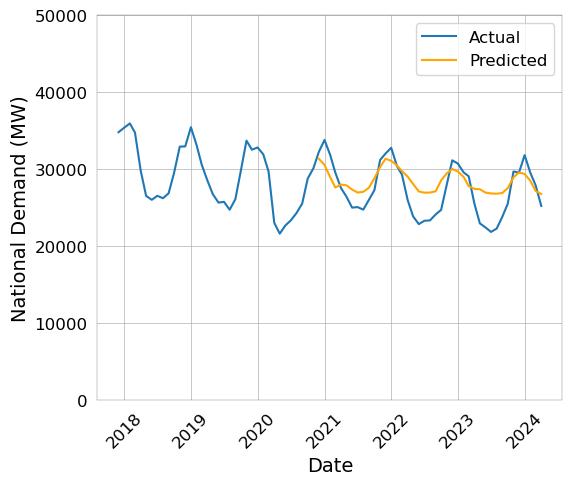


MAPE: 8.405%
RMSE: 2539.386282570701
R2  : 0.4335338246991627



In [65]:
gltoc_run()

plot_fcast_ml(agg_gltoc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltoc, False)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_gltoc, pred_gltoc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_gltoc, pred_gltoc)}
R2  : {r2_score(yts_gltoc, pred_gltoc)}
""")

### LTLF with Exogenous Variables

In [53]:
def gltmc_run() -> list[float]:
    global pred_gltmc
    global yts_gltmc

    ltmc = ltoc[ltoc.index >= pd.to_datetime("2011-01-01")].join(mean_wdat).asfreq("MS")
    
    scaler_gltmc = MinMaxScaler(feature_range=(0, 1))
    
    scaler_gltmc.fit(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    
    sctr_gltmc = scaler_gltmc.transform(ltmc[ltmc.index < pd.to_datetime("2017-01-01")])
    scvl_gltmc = scaler_gltmc.transform(ltmc[(ltmc.index >= pd.to_datetime("2017-01-01")) & (ltmc.index < pd.to_datetime("2020-01-01"))])
    scts_gltmc = scaler_gltmc.transform(ltmc[(ltmc.index >= pd.to_datetime("2020-01-01")) & (ltmc.index < pd.to_datetime("2024-05-01"))])
    
    Xtr_gltmc, ytr_gltmc = df_Xy(sctr_gltmc, SEASON_LTLF)
    Xvl_gltmc, yvl_gltmc = df_Xy(scvl_gltmc, SEASON_LTLF)
    Xts_gltmc, yts_gltmc = df_Xy(scts_gltmc, SEASON_LTLF)
    
    gltmc_model = Sequential()
    gltmc_model.add(InputLayer((SEASON_LTLF, 4)))
    gltmc_model.add(LSTM(512, return_sequences=True))
    gltmc_model.add(LSTM(256))
    gltmc_model.add(Dense(32, 'relu'))
    gltmc_model.add(Dense(4, 'linear'))
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gltmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    gltmc_model.fit(Xtr_gltmc, ytr_gltmc, validation_data=(Xvl_gltmc, yvl_gltmc), epochs=50, callbacks=[cp], verbose=0)
    
    gltmc_model = load_model('intermediate.keras')
    pred_gltmc = gltmc_model.predict(Xts_gltmc, verbose=0)
    
    pred_gltmc = scaler_gltmc.inverse_transform(pred_gltmc)[:,0]
    yts_gltmc = scaler_gltmc.inverse_transform(yts_gltmc)[:,0]

    return [mean_absolute_percentage_error(yts_gltmc, pred_gltmc) * 100, root_mean_squared_error(yts_gltmc, pred_gltmc), r2_score(yts_gltmc, pred_gltmc)]

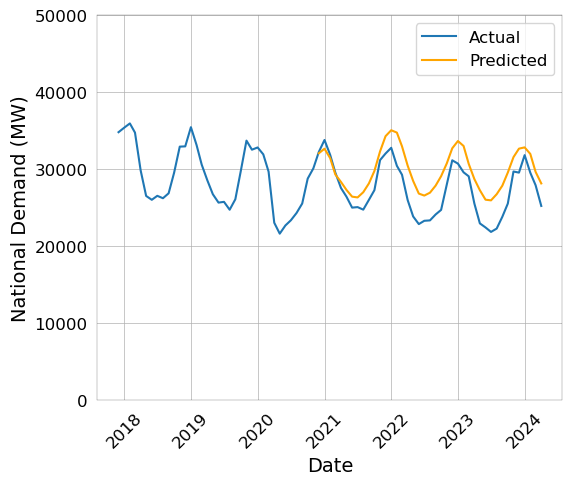


MAPE: 10.173%
RMSE: 2945.5678225883617
R2  : 0.23782535375612257



In [58]:
gltmc_run()

plot_fcast_ml(ltmc, "2017-12-01", "2020-12-01", "2024-05-01", pred_gltmc, True)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_gltmc, pred_gltmc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_gltmc, pred_gltmc)}
R2  : {r2_score(yts_gltmc, pred_gltmc)}
""")

### STLF

In [59]:
def gstoc_run() -> list[float]:
    global pred_gstoc
    global yts_gstoc
    global agg_gstoc

    scaler_gstoc = MinMaxScaler(feature_range=(0, 1))
    
    agg_gstoc = stoc[(stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31"))].asfreq("D")
    
    scaler_gstoc.fit(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    
    sctr_gstoc = scaler_gstoc.transform(agg_gstoc[agg_gstoc.index < pd.to_datetime("2022-05-01")])
    scvl_gstoc = scaler_gstoc.transform(agg_gstoc[(agg_gstoc.index >= pd.to_datetime("2022-05-01")) & (agg_gstoc.index < pd.to_datetime("2022-07-15"))])
    scts_gstoc = scaler_gstoc.transform(agg_gstoc[agg_gstoc.index >= pd.to_datetime("2022-07-15")])
   
    Xtr_gstoc, ytr_gstoc = df_Xy(sctr_gstoc, SEASON_STLF)
    Xvl_gstoc, yvl_gstoc = df_Xy(scvl_gstoc, SEASON_STLF)
    Xts_gstoc, yts_gstoc = df_Xy(scts_gstoc, SEASON_STLF)
   
    gstoc_model = Sequential()
    gstoc_model.add(InputLayer((SEASON_STLF, 1)))
    gstoc_model.add(GRU(256, return_sequences=True))
    gstoc_model.add(GRU(256))
    gstoc_model.add(Dense(8, 'relu'))
    gstoc_model.add(Dense(1, 'linear'))
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    
    gstoc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    gstoc_model.fit(Xtr_gstoc, ytr_gstoc, validation_data=(Xvl_gstoc, yvl_gstoc), epochs=50, callbacks=[cp], verbose=0)
    
    gstoc_model = load_model('intermediate.keras')
    pred_gstoc = gstoc_model.predict(Xts_gstoc, verbose=0)
    
    pred_gstoc = scaler_gstoc.inverse_transform(pred_gstoc)
    yts_gstoc = scaler_gstoc.inverse_transform(yts_gstoc)
    
    return [mean_absolute_percentage_error(yts_gstoc, pred_gstoc) * 100, root_mean_squared_error(yts_gstoc, pred_gstoc), r2_score(yts_gstoc, pred_gstoc)]

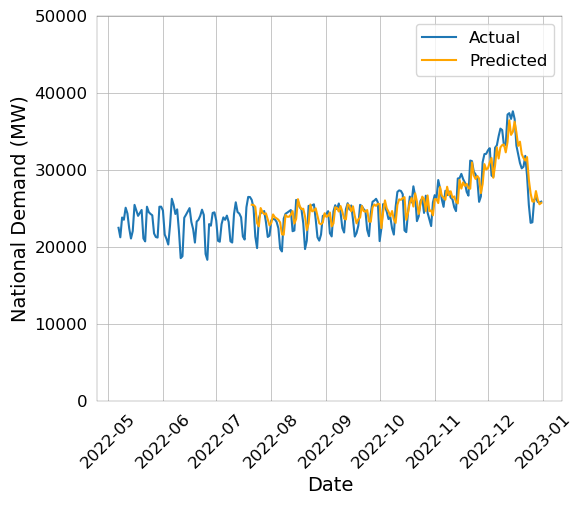


MAPE: 5.227%
RMSE: 1688.4214081636824
R2  : 0.8066752635220703



In [60]:
gstoc_run()

plot_fcast_ml(agg_stoc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstoc, True)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_gstoc, pred_gstoc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_gstoc, pred_gstoc)}
R2  : {r2_score(yts_gstoc, pred_gstoc)}
""")

### STLF with Exogenous Variables

In [61]:
def gstmc_run() -> list[float]:
    global pred_gstmc
    global yts_gstmc
    
    stmc = stoc[((stoc.index >= pd.to_datetime("2022-01-01")) & (stoc.index <= pd.to_datetime("2022-12-31")))].join(mean_dwdat).asfreq("D")
    
    scaler_gstmc = MinMaxScaler(feature_range=(0, 1))
    
    scaler_gstmc.fit(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    
    sctr_gstmc = scaler_gstmc.transform(stmc[stmc.index < pd.to_datetime("2022-05-01")])
    scvl_gstmc = scaler_gstmc.transform(stmc[(stmc.index >= pd.to_datetime("2022-05-01")) & (stmc.index < pd.to_datetime("2022-07-15"))])
    scts_gstmc = scaler_gstmc.transform(stmc[stmc.index >= pd.to_datetime("2022-07-15")])
    
    Xtr_gstmc, ytr_gstmc = df_Xy(sctr_gstmc, SEASON_STLF)
    Xvl_gstmc, yvl_gstmc = df_Xy(scvl_gstmc, SEASON_STLF)
    Xts_gstmc, yts_gstmc = df_Xy(scts_gstmc, SEASON_STLF)
    
    gstmc_model = Sequential()
    gstmc_model.add(InputLayer((SEASON_STLF, 4)))
    gstmc_model.add(LSTM(512, return_sequences=True))
    gstmc_model.add(LSTM(512))
    gstmc_model.add(Dense(32, 'relu'))
    gstmc_model.add(Dense(4, 'linear'))
    
    cp = ModelCheckpoint('intermediate.keras', save_best_only=True)
    gstmc_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    gstmc_model.fit(Xtr_gstmc, ytr_gstmc, validation_data=(Xvl_gstmc, yvl_gstmc), epochs=50, callbacks=[cp], verbose=0)
   
    gstmc_model = load_model('intermediate.keras')
    pred_gstmc = gstmc_model.predict(Xts_gstmc, verbose=0)
    
    pred_gstmc = scaler_gstmc.inverse_transform(pred_gstmc)[:,0]
    yts_gstmc = scaler_gstmc.inverse_transform(yts_gstmc)[:,0]

    return [mean_absolute_percentage_error(yts_gstmc, pred_gstmc) * 100, root_mean_squared_error(yts_gstmc, pred_gstmc), r2_score(yts_gstmc, pred_gstmc)]

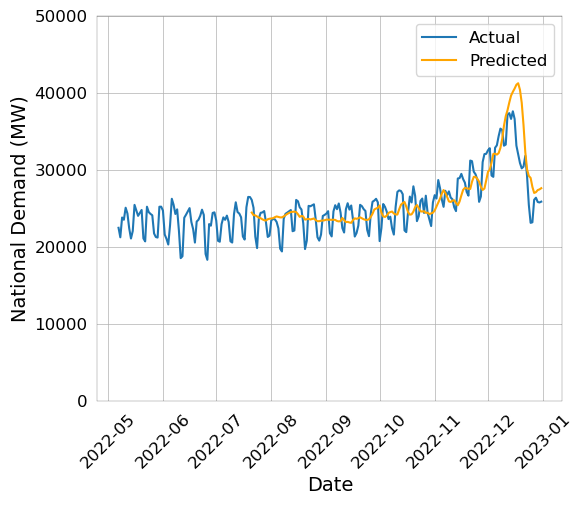


MAPE: 7.252%
RMSE: 2472.6272880134384
R2  : 0.5853868785455301



In [72]:
gstmc_run()

plot_fcast_ml(stmc, "2022-05-07", "2022-07-21", "2023-01-01", pred_gstmc, True)

print(
f"""
MAPE: {mean_absolute_percentage_error(yts_gstmc, pred_gstmc)*100:.3f}%
RMSE: {root_mean_squared_error(yts_gstmc, pred_gstmc)}
R2  : {r2_score(yts_gstmc, pred_gstmc)}
""")

## Metric Averaging

WARNING: do not run unless you are willing to wait for 1.5 - 3hrs (depending on hardware)!

In [ ]:

results = {
    "ltoc":[], "gltoc":[], "stoc":[], "gstoc":[], "ltmc":[], "gltmc":[], "stmc":[], "gstmc":[]
    }

In [ ]:
"""
for i in range(30):
    results["ltoc"].append(ltoc_run())
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["gltoc"].append(gltoc_run())
    print(i+1) """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["stoc"].append(stoc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["gstoc"].append(gstoc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["ltmc"].append(ltmc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["gltmc"].append(gltmc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["stmc"].append(stmc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" 
for i in range(30):
    results["gstmc"].append(gstmc_run())
    print(i+1)
 """

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
""" results["ltoc"] = np.array(results["ltoc"])
results["gltoc"] = np.array(results["gltoc"])
results["stoc"] = np.array(results["stoc"])
results["gstoc"] = np.array(results["gstoc"])
results["ltmc"] = np.array(results["ltmc"])
results["gltmc"] = np.array(results["gltmc"])
results["stmc"] = np.array(results["stmc"])
results["gstmc"] = np.array(results["gstmc"]) """

In [ ]:
""" 
mean_mape_list = [np.mean(results["ltoc"][:,0]), np.mean(results["gltoc"][:,0]), np.mean(results["stoc"][:,0]), np.mean(results["gstoc"][:,0]), 
np.mean(results["ltmc"][:,0]), np.mean(results["gltmc"][:,0]), np.mean(results["stmc"][:,0]), np.mean(results["gstmc"][:,0])]

mean_mape_list
 """

[9.795386170655455,
 9.480186348077583,
 9.595222705810547,
 6.214913297042299,
 7.823793769573811,
 7.485395560714614,
 7.73242975826511,
 7.979619425972847]

In [ ]:
""" mean_rmse_list = [np.mean(results["ltoc"][:,1]), np.mean(results["gltoc"][:,1]), np.mean(results["stoc"][:,1]), np.mean(results["gstoc"][:,1]), 
np.mean(results["ltmc"][:,1]), np.mean(results["gltmc"][:,1]), np.mean(results["stmc"][:,1]), np.mean(results["gstmc"][:,1])]

mean_rmse_list """

[3030.420776319926,
 2899.1274949951044,
 3347.1784011191517,
 2039.6736879254609,
 2354.6982308574597,
 2258.7533075021684,
 2531.3629744459467,
 2591.9430790576384]

In [ ]:
""" mean_r2_list = [np.mean(results["ltoc"][:,2]), np.mean(results["gltoc"][:,2]), np.mean(results["stoc"][:,2]), np.mean(results["gstoc"][:,2]), 
np.mean(results["ltmc"][:,2]), np.mean(results["gltmc"][:,2]), np.mean(results["stmc"][:,2]), np.mean(results["gstmc"][:,2])]

mean_r2_list """

[0.08155518240812688,
 0.21184071619253095,
 0.20229859898469554,
 0.6841274223766756,
 0.49281072792202363,
 0.5400197662295569,
 0.561637121325175,
 0.5376189706336711]